# Task 3

## PyTorch reconstruction from Task 2

In [7]:
# Import statements
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import numpy as np
import torch

In [8]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [9]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

# Center data
mean = np.mean(X_train, axis=0)
X_train-= mean
X_test-= mean

#Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))

#project into PCA subspace
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

(966, 150)
(322, 150)


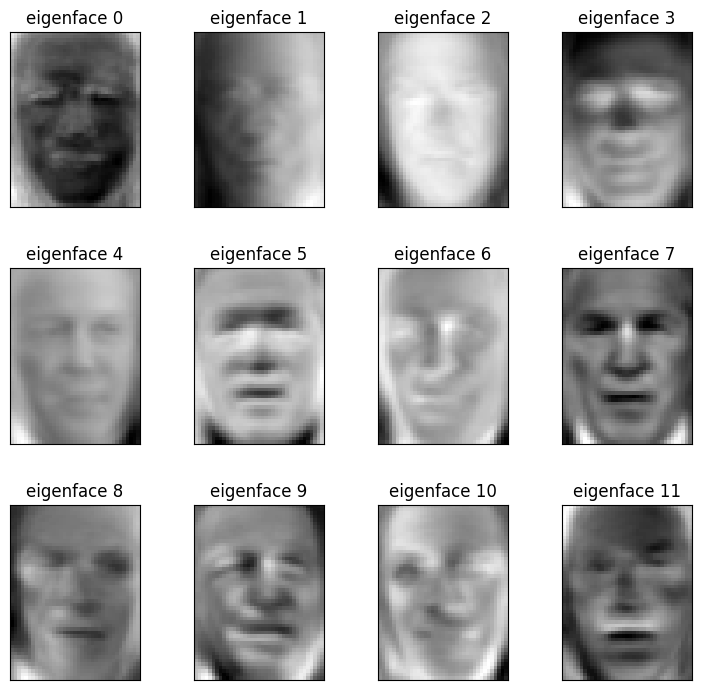

In [10]:
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

(966,)


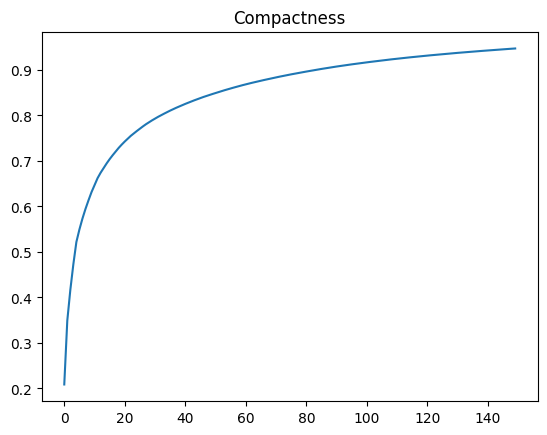

In [11]:
explained_variance = (S ** 2) / (n_samples- 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [12]:
#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]
predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)
print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Predictions [3 3 6 3 4 3 3 1 3 3 3 3 3 3 3 3 4 3 3 4 1 1 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 1 3 1 3 1 1 3 3 3 4 3 3 3 3 3 1 2 1 3 5 3 1 1 3 4 2 5 1 4 1 3 5 6 3 3
 3 2 3 6 3 3 6 3 3 3 3 3 3 3 3 3 3 6 3 3 1 3 1 1 1 6 3 3 3 3 3 3 3 3 3 1 3
 1 6 3 3 3 1 4 1 3 1 3 3 1 3 4 5 3 1 3 6 6 6 3 3 4 3 3 1 3 3 3 3 1 3 3 1 3
 6 1 1 3 3 3 3 3 6 3 3 3 3 5 5 1 3 3 5 1 3 3 3 3 3 1 5 3 3 3 3 5 3 3 1 1 3
 3 3 3 3 2 4 3 2 3 6 3 3 3 3 3 3 3 3 3 5 1 4 2 4 3 3 5 3 3 3 3 3 1 3 3 3 3
 3 1 1 3 3 3 1 3 3 3 3 3 3 1 1 6 3 3 3 4 3 3 3 3 3 3 3 5 4 4 3 4 3 4 3 1 3
 3 3 3 3 1 3 6 6 1 6 1 6 1 3 3 6 3 3 3 3 3 1 1 3 3 3 1 3 3 3 4 3 3 5 3 3 3
 3 6 3 3 3 6 6 3 1 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 5 3]
Which Correct: [ True  True  True  True False  True False  True  True  True  True  True
  True False  True  True False  True  True  True  True False  True False
 False  True False  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False  True
 False  T

C:\Users\nbari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nbari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nbari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

## CNN reconstruction

Epoch 1/15, Train Loss: 1.7344, Val Loss: 1.5154
Epoch 2/15, Train Loss: 1.4874, Val Loss: 1.2841
Epoch 3/15, Train Loss: 1.0136, Val Loss: 1.0253
Epoch 4/15, Train Loss: 0.6723, Val Loss: 0.6777
Epoch 5/15, Train Loss: 0.4152, Val Loss: 0.5496
Epoch 6/15, Train Loss: 0.2638, Val Loss: 0.6013
Epoch 7/15, Train Loss: 0.1708, Val Loss: 0.5262
Epoch 8/15, Train Loss: 0.0966, Val Loss: 0.5168
Epoch 9/15, Train Loss: 0.0523, Val Loss: 0.5424
Epoch 10/15, Train Loss: 0.0317, Val Loss: 0.5350
Epoch 11/15, Train Loss: 0.0211, Val Loss: 0.5417
Epoch 12/15, Train Loss: 0.0103, Val Loss: 0.5998
Epoch 13/15, Train Loss: 0.0052, Val Loss: 0.5761
Epoch 14/15, Train Loss: 0.0033, Val Loss: 0.6068
Epoch 15/15, Train Loss: 0.0027, Val Loss: 0.6314


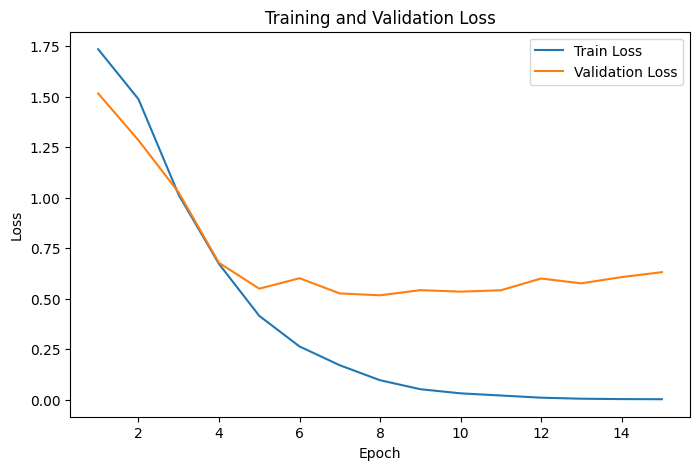

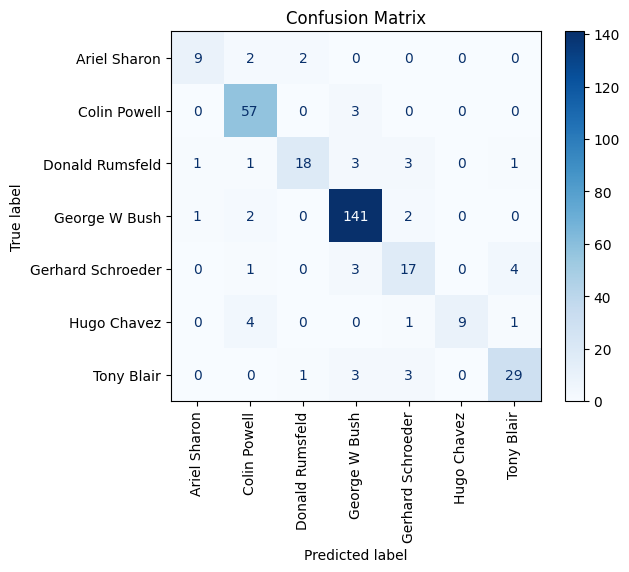

Test Accuracy: 0.8696


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torch

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.images.astype(np.float32)
Y = lfw_people.target
n_samples, h, w = X.shape

# Normalize images to [0, 1]
X /= 255.0 if X.max() > 1.0 else 1.0

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Add channel dimension for PyTorch Conv2D
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

# Convert to PyTorch tensors and move to GPU
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long, device=device)

# DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define CNN model
class LFW_CNN(nn.Module):
    def __init__(self, n_classes):
        super(LFW_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten_size = (h // 2) * (w // 2) * 32  # after one pooling
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, n_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1) # Reshape (flatten)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model
model = LFW_CNN(n_classes=len(lfw_people.target_names)).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with loss tracking
n_epochs = 15
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot training and validation loss
plt.figure(figsize=(8,5))
plt.plot(range(1, n_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, n_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.append(predicted.cpu())
        all_labels.append(y_batch.cpu())
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

accuracy = (all_preds == all_labels).mean()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lfw_people.target_names)
disp.plot(include_values=True, xticks_rotation=90, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print(f"Test Accuracy: {accuracy:.4f}")